# Introdução à Recuperação de Informações

# Lista de Exercícios 2

## Ana Carolina Wagner G. de Barros

___

#### 1. Carregando as bibliotecas e preparando o ambiente

In [1]:
import numpy as np
import pandas as pd
import os

import nltk
from nltk.corpus import machado, mac_morpho
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer

import string

from collections import defaultdict

import enchant
from gensim import corpora, models, similarities

from math import log
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import plotly.plotly as py
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/acwgdb/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy



Organizando os textos de Machado de Assis...

In [2]:
textos = [machado.raw(id) for id in machado.fileids()]

In [3]:
tok_textos = [WordPunctTokenizer().tokenize(t.lower()) for t in textos]
len(set(tok_textos[0]))

7483

Depois de tokenizar, vamos extrair o vocabulário dos textos...

In [4]:
# Gerando vocabulário de palavras únicas de todos os textos
vocab = set([])
for t in tok_textos:
    vocab = vocab.union(set(t))
vocab = map(lambda x:x.lower(),vocab)
vocab = list(set(vocab))
vocab[:3]

['comunicares', 'comprimiu', 'esboroados']

 Agora vamos criar uma coleção de textos, para poder utilizar os métods definidos para esta classe.

In [5]:
# Gerando coleção de textos
T = nltk.TextCollection(tok_textos)

In [6]:
print(str(len(tok_textos)) + ' textos na coleção')
print(str(len(vocab)) + ' palavras únicas na coleção')

246 textos na coleção
66169 palavras únicas na coleção


### Exercício 1: Similaridade por Cosseno.

Com base na metodologia apresentada na Prática 2, usando o corpus de Machado, Construa vetorizações, binárias, por frequência e por tf-idf. Compare a ordenação dos resultados para uma consulta qualquer, com pelo menos 3 palavras. Para a ordenação dos resultados, use o cosseno entre os vetores da consulta e dos documentos.

 Já vimos que a similaridade entre dois cossenos é dada por:$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  Bi} }{ \sqrt{\sum\limits{i=1}^{n}{Ai^2}}  \sqrt{\sum\limits{i=1}^{n}{B_i^2}} }$$

Inicialmente vamos definir uma consulta e tokenizá-la.

In [7]:
q = "Lamartine elixir harpa"
qt = WordPunctTokenizer().tokenize(q.lower())

Calculando valores de frequência sobre a consulta. Definindo as matrizes...

In [8]:
# Frequência binária
binary_matrix = np.zeros((len(tok_textos),len(qt)))
# Frequência no texto
tf_matrix = np.zeros((len(tok_textos),len(qt)))
# Frequência por tf_idf
tfidf_matrix = np.zeros((len(tok_textos),len(qt)))

for j, termo in enumerate(qt):
    for i, texto in enumerate(tok_textos):
        tfidf_matrix[i,j] = T.tf_idf(termo,texto)
        tf_matrix[i,j] = T.tf(termo,texto)
        if tf_matrix[i,j] > 0:
            binary_matrix[i,j] = 1

Vetorizando e ordenando os valores...

In [9]:
def ordem(q,MN):
    return [np.dot(q,r) for r in MN]

In [10]:
from numpy.linalg import norm

# Matrizes normalizadas
Mbin_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in binary_matrix])
Mtf_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tf_matrix])
Mtfidf_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tfidf_matrix])

In [11]:
# Construção dos vetores ordenados
vetor_tfidf = np.array([T.tf_idf(w,qt) for w in qt])
vetor_tfidf /= norm(vetor_tfidf)
resp_tfidf = ordem(vetor_tfidf,Mtfidf_Norm)

vetor_tf = np.array([T.tf(w,qt) for w in qt])
vetor_tf /= norm(vetor_tf)
resp_tf = ordem(vetor_tf,Mtf_Norm)

vetor_bin = np.ones(len(qt))
vetor_bin /= norm(vetor_bin)
resp_bin = ordem(vetor_bin,Mbin_Norm)

In [12]:
vbin = filter(lambda x : x[0]!=0.0, zip(resp_bin,range(len(tok_textos))))
vtf = filter(lambda x : x[0]!=0.0, zip(resp_tf,range(len(tok_textos))))
vtfidf = filter(lambda x : x[0]!=0.0, zip(resp_tfidf,range(len(tok_textos))))

In [13]:
# Resposta ordenada
resposta_bin = sorted(vbin, reverse=True)
resposta_tf = sorted(vtf, reverse=True)
resposta_tfidf = sorted(vtfidf, reverse=True) 

#### Vetorização binária

In [14]:
print(binary_matrix.shape)
binary_matrix[:3,:]

(246, 3)


array([[ 1.,  1.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

 Vamos agora visualizar os vetores:

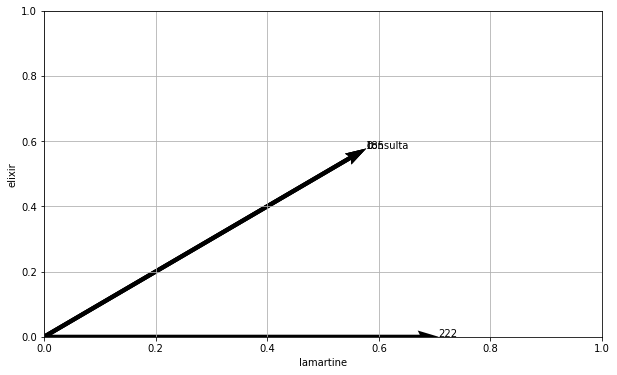

In [16]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
docs = 3
vecs = [vetor_bin[:2]]
for d in resposta_bin[:docs]:
    vecs.append(Mbin_Norm[d[1]][:2])
    x,y = Mbin_Norm[d[1]][:2]
    plt.text(x,y,'{}'.format(d[1]))
U, V = zip(*vecs)
x,y = zeros(docs+1), zeros(docs+1)
plt.text(U[0],V[0],'consulta')
plt.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('lamartine')
ax.set_ylabel('elixir')
ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);

#### Vetorização por frequência

In [17]:
print(tf_matrix.shape)
tf_matrix[:3,:]

(246, 3)


array([[  1.43837291e-05,   2.87674583e-05,   1.43837291e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

Vamos agora visualizar os vetores:

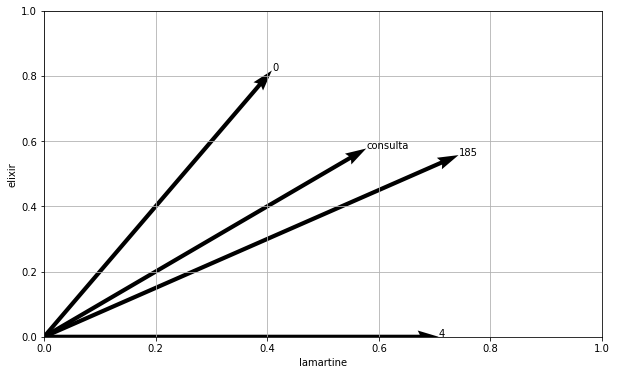

In [19]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
docs = 3
vecs = [vetor_tf[:2]]
for d in resposta_tf[:docs]:
    vecs.append(Mtf_Norm[d[1]][:2])
    x,y = Mtf_Norm[d[1]][:2]
    plt.text(x,y,'{}'.format(d[1]))
U, V = zip(*vecs)
x,y = zeros(docs+1), zeros(docs+1)
plt.text(U[0],V[0],'consulta')
plt.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('lamartine')
ax.set_ylabel('elixir')
ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);

#### Vetorização por TF-IDF

In [20]:
print(tfidf_matrix.shape)
tfidf_matrix[:3,:]

(246, 3)


array([[  4.34449734e-05,   9.51658288e-05,   4.12277118e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

Vamos agora visualizar os vetores:

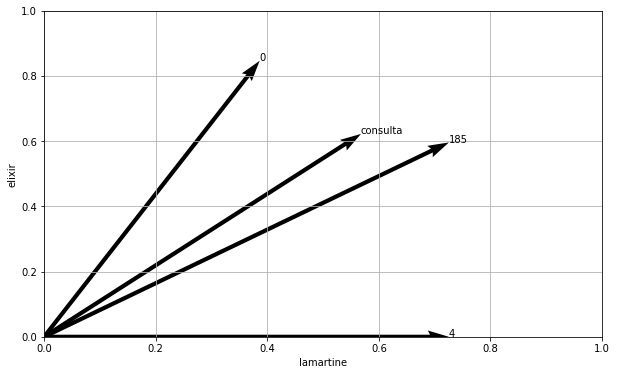

In [22]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
docs = 3
vecs = [vetor_tfidf[:2]]
for d in resposta_tf[:docs]:
    vecs.append(Mtfidf_Norm[d[1]][:2])
    x,y = Mtfidf_Norm[d[1]][:2]
    plt.text(x,y,'{}'.format(d[1]))
U, V = zip(*vecs)
x,y = zeros(docs+1), zeros(docs+1)
plt.text(U[0],V[0],'consulta')
plt.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('lamartine')
ax.set_ylabel('elixir')
ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);

Em resumo:

In [23]:
x = 10
print('Vetorização Binária)
print(resposta_bin[:x])
print('\n')
print('Vetorização por Frequência)
print(resposta_tf[:x])
print('\n')
print('Vetorização por TF-IDF)
print(resposta_tfidf[:x])

[(1.0000000000000002, 185), (1.0000000000000002, 0), (0.81649658092772603, 222), (0.81649658092772603, 217), (0.81649658092772603, 193), (0.81649658092772603, 4), (0.57735026918962584, 240), (0.57735026918962584, 238), (0.57735026918962584, 232), (0.57735026918962584, 229)]


[(0.96490128135401543, 185), (0.94280904158206336, 0), (0.81649658092772603, 4), (0.77459666924148329, 217), (0.67131711334261879, 193), (0.65319726474218076, 222), (0.57735026918962573, 240), (0.57735026918962573, 238), (0.57735026918962573, 232), (0.57735026918962573, 229)]


[(0.96828908936389757, 185), (0.9435141616147088, 0), (0.78297901914356116, 4), (0.74416385783148287, 217), (0.67850278296095257, 193), (0.6220481135579361, 238), (0.6220481135579361, 229), (0.6220481135579361, 138), (0.6220481135579361, 85), (0.6220481135579361, 41)]


Assim, como podemos observar, a consulta realizada apresenta resultados parecidos entre os três tipos de frequência calculada. 

Apesar de quando ordenados, os documentos assumam posições diferentes, individualmente eles se encontram em posições próximas nos vetores.

### Exercício 2: Explorando o conceito de similaridade.

Construa uma matriz de similaridade (cossenos entre vetores de frequência) entre todos os textos de machado. 
Construa um histograma com os valores de similaridade, excluindo os 0s e 1s. Interprete.

Agora, a ideia é compararmos como a frequência das palavras únicas se diferenciam entre os textos.

In [45]:
vetor = TfidfVectorizer(min_df=1)
tfidf = vetor.fit_transform(textos)
matriz = (tfidf * tfidf.T).A
print (matriz)

[[ 1.          0.81896149  0.83046457 ...,  0.29386488  0.65654999
   0.58979922]
 [ 0.81896149  1.          0.84636708 ...,  0.2857949   0.66699573
   0.59418853]
 [ 0.83046457  0.84636708  1.         ...,  0.28538606  0.70631686
   0.6081249 ]
 ..., 
 [ 0.29386488  0.2857949   0.28538606 ...,  1.          0.21823833
   0.21724236]
 [ 0.65654999  0.66699573  0.70631686 ...,  0.21823833  1.          0.49688348]
 [ 0.58979922  0.59418853  0.6081249  ...,  0.21724236  0.49688348  1.        ]]


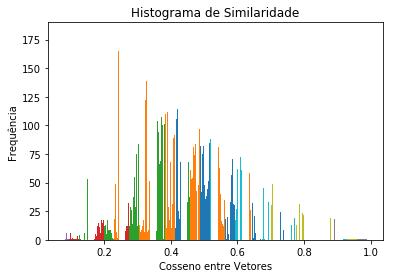

In [46]:
plt.hist(matriz)          
plt.title("Histograma de Similaridade")
plt.xlabel("Cosseno entre Vetores")
plt.ylabel("Frequência")

###  Exercício 3: Usando o Gensim

Instale o Gensim, se ainda não o tiver. Seguindo o início deste tutorial: https://radimrehurek.com/gensim/tut2.html, construa um corpus usando as classes do Gensim, mas com os textos de Machado.

In [47]:
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer
from collections import Counter
from string import punctuation

In [48]:
sw = stopwords.words('portuguese')+ list(punctuation)
stemmer = PortugueseStemmer()

Vamos tokenizar, normalizar e remover stopwords dos textos.

In [49]:
textos_limpos = []
c = Counter([])
for texto in textos:
    tlimpo = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in sw]
    c.update(tlimpo)
    textos_limpos.append(tlimpo)
textos_limpos = [[token for token in t if c[token]>1] for t in textos_limpos]

Vamos gerar um 'dicionário' para as palavras únicas de forma que cada palavra tenha um id correspondente

In [50]:
dicionario = corpora.Dictionary(textos_limpos)
dicionario.save('vocabulario.dict')
print(dicionario)

Dictionary(18033 unique tokens: ['', '10', '11', '15', '186']...)


Em seguida, geramos o corpus que irá relacionar o 'id' da palavra com sua frequência no texto.

In [66]:
corpus = [dicionario.doc2bow(d) for d in textos_limpos]
corpora.MmCorpus.serialize('machado.mm', corpus)

In [70]:
corpus[0][:10]

[(0, 423),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 3),
 (9, 1)]

###  Exercício 4: Indexação Semântica Latente.

Ainda seguindo  o tutorial citado no exercício anterior, ajuste um modelo LSI para os documentos de machado. Interprete os resultados.

Para gerar o modelo LSI de forma otimizada é aconselhavel utilizar o corpus gerado pelo modelo TF-IDF.

In [71]:
# Construção do modelo TF-IDF
mod_tfidf = models.TfidfModel(corpus)
corpus_tfidf = mod_tfidf[corpus]

In [77]:
# Construção do modelo LSI
mod_lsi = models.LsiModel(corpus_tfidf, id2word=dicionario, num_topics=300)
corpus_lsi = mod_lsi[corpus_tfidf]

Vamos ver o quanto os 10 primeiros tópicos caracterizam o 'assunto' do primeiro texto do nosso corpus.

In [78]:
corpus_lsi[0][:10]

[(0, 0.35909968059313963),
 (1, -0.23791592809935425),
 (2, 0.19424725002732221),
 (3, -0.0099058305672971598),
 (4, 0.072462367617181986),
 (5, -0.15004772232230895),
 (6, 0.016721197348862717),
 (7, 0.2377475292392639),
 (8, -0.16785187022205239),
 (9, 0.064489892734064719)]

In [79]:
mod_lsi.print_topics(3)

[(0,
  '0.302*"\x97" + 0.109*"sr" + 0.094*"poet" + 0.086*"luís" + 0.065*"crític" + 0.065*"camil" + 0.064*"\x93" + 0.062*"vers" + 0.059*"d" + 0.059*"jos"'),
 (1,
  '-0.385*"\x97" + 0.154*"sr" + 0.150*"crític" + -0.144*"luís" + 0.137*"poet" + 0.131*"dramát" + 0.120*"alenc" + -0.103*"camil" + 0.101*"autor" + 0.100*"poes"'),
 (2,
  '0.308*"luís" + -0.240*"henriquet" + 0.142*"daniel" + 0.138*"jorg" + 0.137*"marcelin" + 0.132*"tit" + 0.129*"carlot" + 0.129*"poet" + 0.128*"cecíl" + 0.127*"alves"')]

Interpretando os resultados...

* Existem nos textos alguns símbolos que podem atrapalhar na análise.

* Apesar disso, parece existir alguma relação entre os termos 'x97' e 'sr'. De fato, parece que esses termos são os maiores determinantes do quanto um texto está relacionado ao primeiro tópico, por exemplo.  